In [47]:
import requests,operator,pandas,glob2
from bs4 import BeautifulSoup
from datetime import datetime
import nltk
from konlpy.tag import Twitter
from matplotlib import font_manager,rc
font_name=font_manager.FontProperties(fname="/media/young/5e7be152-8ed5-483d-a8e8-b3fecfa221dc/font/NanumFont/NanumGothic.ttf").get_name()
rc('font',family=font_name)
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
t=Twitter()

# This method analyzes crawled data
def analyze(content):
    # Convert content into string and then convert string into noun
    nouns=t.nouns(str(content))
    # I create list of useless words
    trash=["조선","연합뉴스","일보","중앙","기자","뉴스","헤럴드경제"]
    for i in trash:
        for j in nouns:
            # If element of i and element of j are same,
            # If trash==noun,
            if i==j:
                # remove ith corresponding trash word in "nouns"
                nouns.remove(i)
    # I convert "nouns" with format of name="분석"
    ko=nltk.Text(nouns,name="분석")
    # Find most common 100 words from "ko"
    ranking=ko.vocab().most_common(100)
    # Convert "ranking" into dictionary
    tmpData=dict(ranking)
    # < {"국회":7,"자유":6,...}
    # Create wordcloud instance with setting it
    wordcloud=WordCloud(font_path="/media/young/5e7be152-8ed5-483d-a8e8-b3fecfa221dc/font/NanumFont/NanumGothic.ttf"\
                ,relative_scaling=0.2\
                ,background_color="white",).generate_from_frequencies(tmpData)
    # Configure size to 16*8 image
    plt.figure(figsize=(16,8))
    # Pass configured wordcloud instance
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [49]:
def crawlingData(date,pageCount):
    now=datetime.now()
    l=[]
    for pagecount in range(1,int(pageCount)):
        r=requests.get("http://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1=100&date="\
                    +str(date)+"&page="+str(pageCount))
        c=r.content
        soup=BeautifulSoup(c,"html.parser")
        all=soup.find_all("li")
        for item in all:
            for item2 in item.find_all("dl"):
                d={}
                try:
                    linkTag=item2.find("dt",{"class":""}).find("a")
                    d["LinkSrc"]=linkTag["href"]
                    d["Title"]=linkTag.text\
                                    .replace("\t","")\
                                    .replace("\n","")\
                                    .replace(",","")\
                                    .replace('"',"")\
                                    .replace("\r","")[1:len(linkTag.text)+1]
                except:    
                    d["LinkSrc"]="None"
                    d["Title"]="None"
                    
                try:
                    contentTag=item2.find("dd")
                    d["Content"]=\
                    contentTag.text\
                            .replace("\t","")\
                            .replace("\n","")\
                            .replace("\r","")\
                            .replace(",","")\
                            .replace('"',"")\
                            .split("…")[0]
                
                    d["Company"]=contentTag.find("span",{"class":"writing"}).text
                    d["Date"]=contentTag.find("span",{"class":"date"}).text
#                     print(d["Content"])
                except:
                    d["Content"]="None"
                    d["Company"]="None"
                    d["Date"]="None"
                    
                try:
                    imgTag=item2.find("dt",{"class":"photo"}).find("img")
                    d["imgSrc"]=imgTag["src"]
                except:
                    d["imgSrc"]="No image"
                    
                l.append(d)
                
    df=pandas.DataFrame(l)
    df.to_csv('%s-%s-%s-%s-%s-%s.csv'\
             %(now.year,now.month,now.day,now.hour,now.minute,now.second)\
             ,encoding='utf-8-sig'\
             ,index=False)
    print(df)
    print("get datafile and save data successfully")
    

In [50]:
def loadFile(fileName,analyzeValue):
    outputFileName=checkFileName(fileName)
    if outputFileName is not -1:
        df=pandas.read_csv(outputFileName)
        content=df["Content"]
        title=df["Title"]
        company=df["Company"]
        print("csv FIle Load Success")
        if analyzeValue==1:
            analyze(content)
    else:
        print("error during loading csv file")

In [51]:
def checkFileName(fileName):
    now=datetime.now()
    if len(glob2.glob("*.csv"))==0:
        print("No file found in this directory")
        return -1
    else:
        if fileName=="all":
            result=[]
            for i in glob2.glob("*.csv"):
                result.append(pandas.read_csv(i))
            outputFileName='%s-%s-%s-%s-%s-%s-merging.csv'\
                        %(now.year,now.month,now.day,now.hour,now.minute,now.second)
            resultDf=pandas.concat(result,ignore_index=True)
            resultDf.to_csv(outputFileName,encoding='utf-8-sig')
            return outputFileName
        else:
            return fileName

In [53]:
def mainSetting():
    while(1):
        kb=input("input exit or crawling or loadAll or load: ")
        if kb=="exit":
            break
        elif kb=="crawling":
            date=input("input news date(format:20170101): ")
            page=input("input news page(format:4): ")
            crawlingData(date,page)
            break
        elif kb=="loadAll":
            loadFile("all")
            break
        elif kb=="load":
            fileName=input("input your csv file name: ")
            loadFile(fileName,0)
            break
        elif kb=="analyze":
            fileName=input("input your csv file name: ")
            loadFile(fileName,1)
            break
        else:
            print("command is not defined")
            break

            
mainSetting()            

   Company                                            Content     Date  \
0     경향신문                                     ㆍ“봄이 온다 가을이 왔다  15시간전\t   
1     경향신문                                    ㆍ남측 북 삼지연악단과 공연  15시간전\t   
2     연합뉴스                                         이러다가 다 죽는다  15시간전\t   
3     JTBC  1. 북한 실무회담 5일로 연기 제의 남북 정상회담 준비를 위해 내일(4일) 열기로...  15시간전\t   
4     경향신문  ㆍ민주당 광역단체장 6곳 경선 없이 단수 공천·추대 ㆍ“남북정상회담 전 마무리” 여...  15시간전\t   
5     경향신문                                       ㆍ공영방송 독립성 규정  15시간전\t   
6     경향신문                                        ㆍ재·보선 최소 8곳  15시간전\t   
7    오마이뉴스  [적폐탐정단 : 국회사무처⑨] 내부자의 단호한 한 마디 국회 주인은 관료다 [오마이...  15시간전\t   
8     매일경제  한국과 북한의 예술단이 3일 오후 3시30분(한국시간) 평양 류경정주영체육관에서 열...  15시간전\t   
9    스포츠경향  자유한국당 권성동 의원(사진)이 “1987년 현행 헌법이 채택된 뒤 여러 대통령을 ...  15시간전\t   
10    중앙일보  남북 예술단이 눈물과 감동 속에 합동공연을 마쳤다. 남북 예술단은 3일 오후 평양 ...  16시간전\t   
11  KBS 뉴스  공군 부사관인 외삼촌으로부터 폭행을 당한 소년이 숨져 헌병대가 수사 중이다. 공군은...  16시간전\t   
12    경향신문  ㆍ70년 추념사서 ‘국가폭력’ 사과 ㆍ“제주도민

csv FIle Load Success


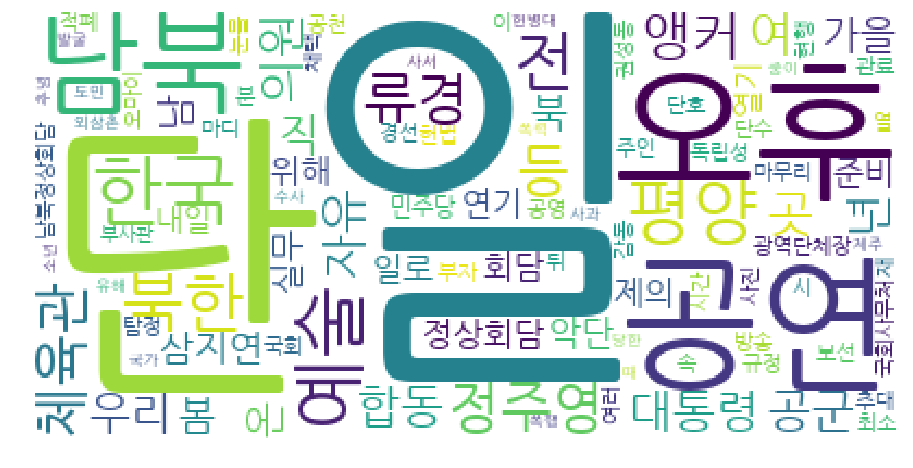

In [54]:
def mainSetting():
    while(1):
        kb=input("input exit or crawling or loadAll or load: ")
        if kb=="exit":
            break
        elif kb=="crawling":
            date=input("input news date(format:20170101): ")
            page=input("input news page(format:4): ")
            crawlingData(date,page)
            break
        elif kb=="loadAll":
            loadFile("all")
            break
        elif kb=="load":
            fileName=input("input your csv file name: ")
            loadFile(fileName,0)
            break
        elif kb=="analyze":
            fileName=input("input your csv file name: ")
            loadFile(fileName,1)
            break
        else:
            print("command is not defined")
            break

            
mainSetting()            